## 1. libraries import and setup

In [1]:
import os
import geopandas as gpd
import rioxarray as rxr
#from rasterio.plot import show
from matplotlib import pyplot as plt
import rasterio
from rasterio.plot import show
import numpy as np
import xarray as xr
from shapely.geometry import box
from pathlib import Path
import importlib.util

In [2]:
# load the setup.py module
path = Path.cwd().parent / 'src' / 'setup.py'
spec = importlib.util.spec_from_file_location('setup', path)
setup = importlib.util.module_from_spec(spec)
spec.loader.exec_module(setup)

# call the make_folders function
raw_data_dir, processed_data_dir, output_dir = setup.make_folders()

created directory data\raw_data\nDSM
created directory data\raw_data\DOP
created directory data\raw_data\gaps_poly
created directory data\processed_data
created directory data\metadata
created directory output


## 2. data reading

In [15]:
# read DOPs
dop_path = raw_data_dir / 'DOP'

dop_train = rxr.open_rasterio(dop_path / 'dop_limker-strang_2019.tif',
                              band_as_variable = True)
dop_test = rxr.open_rasterio(dop_path / 'dop_luessberg_2019.tif',
                              band_as_variable = True)

print(dop_train)
print(dop_test)

<xarray.Dataset>
Dimensions:      (x: 23554, y: 37587)
Coordinates:
  * x            (x) float64 5.444e+05 5.444e+05 ... 5.488e+05 5.488e+05
  * y            (y) float64 5.734e+06 5.734e+06 ... 5.727e+06 5.727e+06
    spatial_ref  int32 0
Data variables:
    band_1       (y, x) uint16 ...
    band_2       (y, x) uint16 ...
    band_3       (y, x) uint16 ...
    band_4       (y, x) uint16 ...
Attributes:
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  2 (pixels/inch)
    TIFFTAG_SOFTWARE:        E
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
<xarray.Dataset>
Dimensions:      (x: 23317, y: 37083)
Coordinates:
  * x            (x) float64 5.873e+05 5.873e+05 ... 5.919e+05 5.919e+05
  * y            (y) float64 5.859e+06 5.859e+06 ... 5.851e+06 5.851e+06
    spatial_ref  int32 0
Data variables:
    band_1       (y, x) uint16 ...
    band_2       (y, x) uint16 ...
    band_3       (y, x) uint16 ...
    band_4       (y, x) uint16 ...
Attributes:
    AREA_OR_PO

In [16]:
# read gap polygons
gaps_poly_path = raw_data_dir / 'gaps_poly'

gaps_poly_train = gpd.read_file(gaps_poly_path / 'limk_19_poly.shp')
gaps_poly_test = gpd.read_file(gaps_poly_path / 'luess_2019_poly_final.shp')

print(gaps_poly_train)
print(gaps_poly_test)

       ID_1     AREA  N_RAND_14  Perimeter  Bemerkunge lg_attach  \
0       500   47.353          0        0.0         NaN       NaN   
1       501   24.406          0        0.0         NaN       NaN   
2       502   21.648          0        0.0         NaN       NaN   
3       503   34.133          0        0.0         NaN       NaN   
4       504   60.527          0        0.0         NaN       NaN   
..      ...      ...        ...        ...         ...       ...   
128     547   85.183          0        0.0         NaN       NaN   
129       0   14.945          0        0.0         NaN       NaN   
130       0   15.779          0        0.0         NaN       NaN   
131     515  374.701          0        0.0         NaN       NaN   
132  302602  729.805          0        0.0         NaN       NaN   

                                              geometry  
0    POLYGON Z ((546475.360 5730134.031 432.462, 54...  
1    POLYGON Z ((546448.631 5730152.592 425.877, 54...  
2    POLYGON

Text(0.5, 1.0, 'gap polygons for testing')

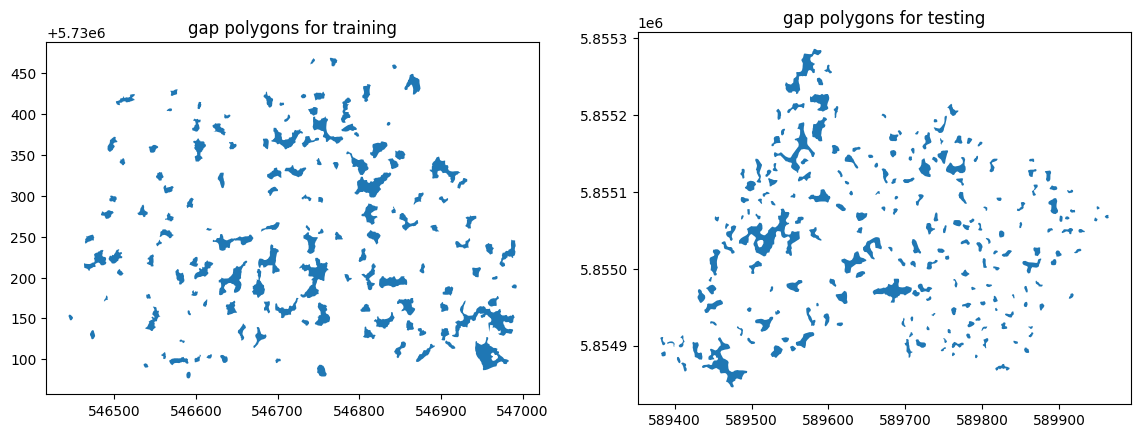

In [19]:
# quick view
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,8))
gaps_poly_train.plot(ax=ax1)
ax1.set_title('gap polygons for training')
gaps_poly_test.plot(ax=ax2)
ax2.set_title('gap polygons for testing')

## 3. data preparation
### 3.1 clipping the DOPs to the extent of the respective canopy gaps layer

In [21]:
# define path to the clipped DOP
dop_train_clipped_path = processed_data_dir / 'dop_train_clipped.tif'
dop_test_clipped_path = processed_data_dir / 'dop_test_clipped.tif'

# check if clipped DOP files already exists
if not dop_train_clipped_path.exists() or not dop_test_clipped_path.exists():

    # get bounding box of the gap polygons
    bbox_train = gaps_poly_train.total_bounds
    bbox_test  = gaps_poly_test.total_bounds

    # create bounding box polygons
    bbox_train_poly = box(*bbox_train)
    bbox_test_poly  = box(*bbox_test)

    # clip DOPs to the respective bounding box polygon extent (gaps extent)
    dop_train_clipped = dop_train.rio.clip([bbox_train_poly], dop_train.rio.crs)
    dop_test_clipped  = dop_test.rio.clip([bbox_test_poly], dop_test.rio.crs)

    # save clipped DOPs
    dop_train_clipped.rio.to_raster(dop_train_clipped_path)
    dop_test_clipped.rio.to_raster(dop_test_clipped_path)
    print('DOPs successfully clipped and saved.')

else:

    # load existing clipped DOPs
    dop_train_clipped = rxr.open_rasterio(dop_train_clipped_path, band_as_variable = True)
    dop_test_clipped = rxr.open_rasterio(dop_test_clipped_path, band_as_variable = True)
    print('Existing clipped DOPs loaded.')

DOPs successfully clipped and saved.


### 3.2 normalization of the band values for plotting tasks 

In [24]:
# store both clipped DOPs in a list
dops = [dop_train_clipped, dop_test_clipped]

# create empty list to store the normalized DOPs
normalized_dops = []

# normalize the clipped DOPs
for dop in dops:
    # normalize uint16 data to [0, 255]
    normalized_dop = (dop - dop.min()) / (dop.max() - dop.min()) * 255
    # convert normalized bands to uint8
    normalized_dop = normalized_dop.astype(np.uint8)
    normalized_dops.append(normalized_dop)

In [27]:
print(normalized_dops[0])
print(normalized_dops[1])

<xarray.Dataset>
Dimensions:      (y: 2086, x: 2916)
Coordinates:
  * x            (x) float64 5.464e+05 5.464e+05 5.464e+05 ... 5.47e+05 5.47e+05
  * y            (y) float64 5.73e+06 5.73e+06 5.73e+06 ... 5.73e+06 5.73e+06
    spatial_ref  int32 0
Data variables:
    band_1       (y, x) uint8 39 51 66 67 60 55 59 60 ... 41 51 54 53 46 41 51
    band_2       (y, x) uint8 36 53 74 73 64 58 64 67 ... 42 54 58 55 44 35 47
    band_3       (y, x) uint8 54 75 101 101 88 81 88 91 ... 73 88 92 89 74 62 75
    band_4       (y, x) uint8 105 118 134 132 121 115 118 ... 48 49 45 35 28 35
<xarray.Dataset>
Dimensions:      (y: 2240, x: 2967)
Coordinates:
  * x            (x) float64 5.894e+05 5.894e+05 5.894e+05 ... 5.9e+05 5.9e+05
  * y            (y) float64 5.855e+06 5.855e+06 ... 5.855e+06 5.855e+06
    spatial_ref  int32 0
Data variables:
    band_1       (y, x) uint8 29 36 46 46 54 47 39 34 ... 44 50 50 45 44 43 45
    band_2       (y, x) uint8 33 42 53 53 62 53 42 34 ... 45 53 54 47 44 43 4

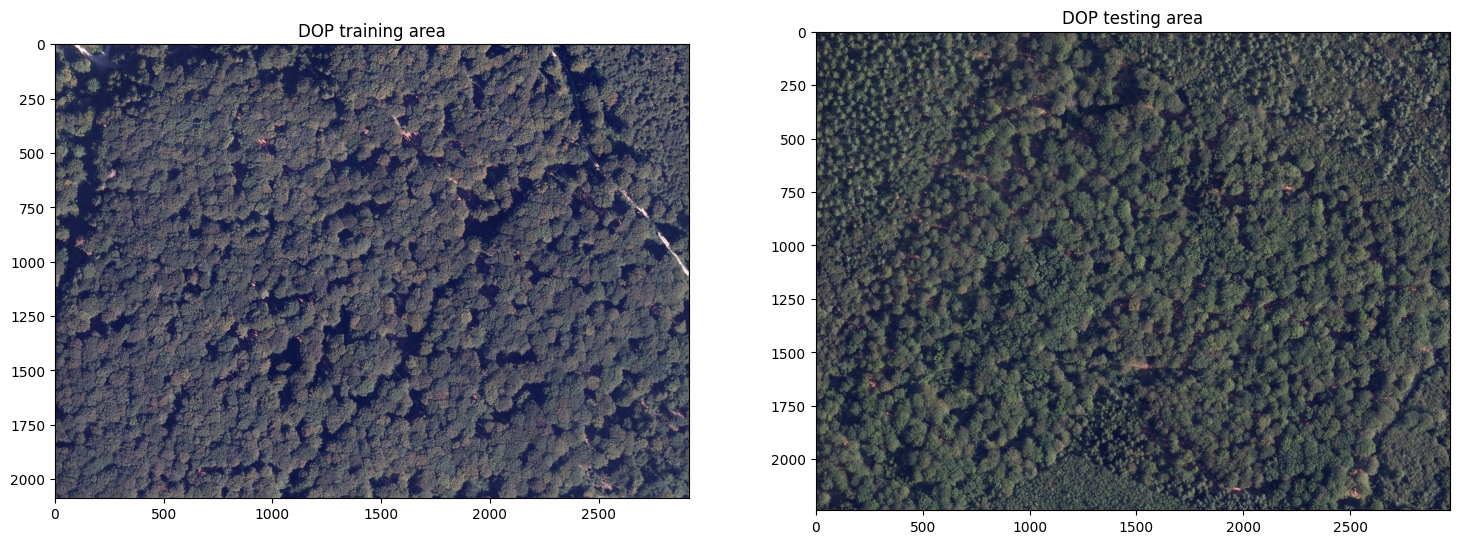

In [36]:
# plot clipped DOPs
fig, ax = plt.subplots(1,2,figsize=(18,12))
ax[0].imshow(np.array([normalized_dops[0].band_1, normalized_dops[0].band_2, normalized_dops[0].band_3]).transpose(1,2,0))
ax[0].set_title('DOP training area')
ax[1].imshow(np.array([normalized_dops[1].band_1, normalized_dops[1].band_2, normalized_dops[1].band_3]).transpose(1,2,0))
ax[1].set_title('DOP testing area')
plt.show()

### testing...

In [13]:
#src = rasterio.open(dop_path)
#src

In [14]:
#src.profile

In [11]:
#dop_path = raw_data_dir + 'DOP/dop_limker-strang_2019.tif'

#with rasterio.open(dop_path) as src:
#    red = src.read(1)
#    green = src.read(2)
#    blue = src.read(3)
#    nir = src.read(4)

In [18]:
# stack the color bands to create a true-color image (RGB)
#rgb_image = [red, green, blue]
#rgb_image = [band.astype('float64') / 255.0 for band in rgb_image]
#rgb_image = np.stack(rgb_image, axis=-1)

In [ ]:
# plot the true-color (RGB) image
#plt.figure(figsize=(10, 8))
#plt.imshow(rgb_image)
#plt.show()